# Final classical syndrome/codeword decoder

Classical LDPC matrices are stored in "files/[name].npy" from working directory

The notation used here will borrow from the following blog post [here](https://arthurpesah.me/blog/2022-05-21-classical-error-correction/)

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr
# from ldpc.codes import rep_code
import time
from scipy.io import savemat


In [38]:
file1  = 'Dv2Dc3_G18_N114.npy'
file2  = 'Dv2Dc6_G8_N36.npy'

#classical
CM1 = np.load('files/'+file1)
CM2 = np.load('files/'+file2)

In [39]:
altCM1 = np.transpose(CM1)
altCM2 = np.transpose(CM2)
# savemat('altH1.mat', {'altH1':AIk(altCM1)})
# savemat('altH2.mat', {'altH2':AIk(altCM2)})
# savemat('CM1.mat', {'CM1':CM1})

In [43]:
def gaussianElimination(matrix, columns=None, diagonalize=True,
                        successfulCols=None, q=2):
        """
        gaussianElimination(matrix, columns=None, diagonalize=True, successfulCols=None, q=2)

        The Gaussian elimination algorithm in :math:`\mathbb F_q` arithmetics, turning a given
        matrix into reduced row echelon form by elementary row operations.

        .. warning:: This algorithm operates **in-place**!

        Parameters
        ----------
        matrix : np.int_t[:,::1]
            The matrix to operate on.
        columns : np.intp_t[:], optional
            A sequence of column indices, giving the the order in which columns of the matrix are
            visited. Defaults to ``range(matrix.shape[1])``.
        diagonalize : bool, True
            If ``True``, matrix elements above the pivots will be turned to zeros, leading to a
            diagonal submatrix. Otherwise, the result contains an upper triangular submatrix.
        successfulCols : np.intp_t[::1], optinonal
            Numpy array in which successfully diagonalized column indices are stored. If supplied,
            this array will be used for the return value. Otherwise, a new array will be created,
            resulting in a slight performance drain.
        q : int, optional
            Field size in which operations should be performed. Defaults to ``2``.

        Returns
        -------
        np.intp_t[::1]
            Indices of successfully diagonalized columns.
        """
        nrows = matrix.shape[0]
        ncols = matrix.shape[1]
        curRow = 0
        colIndex = 0
        numSuccessfulCols = 0
        # assert q < cachedInvs.shape[0]

        if successfulCols is None:
            successfulCols = np.empty(nrows, dtype=np.intp)
        if columns is None:
            columns = np.arange(ncols, dtype=np.intp)
        while True:
            if colIndex >= columns.shape[0]:
                break
            curCol = columns[colIndex]
            # search for a pivot row
            pivotRow = -1
            for row in range(curRow, nrows):
                val = matrix[row, curCol]
                if val != 0:
                    pivotRow = row
                    break
            if pivotRow == -1:
                # did not find a pivot row -> this column is linearly dependent of the previously
                # visited; continue with next column
                colIndex += 1
                continue
            if pivotRow > curRow:
                # swap rows
                for i in range(ncols):
                    val = matrix[curRow, i]
                    matrix[curRow, i] = matrix[pivotRow, i]
                    matrix[pivotRow, i] = val
            # do the actual pivoting
            if matrix[curRow, curCol] > 1:
                # "divide" by pivot element to set it to 1
                if q > 2:
                    factor = cachedInvs[q, matrix[curRow, curCol]]
                    for i in range(ncols):
                        matrix[curRow, i] = (matrix[curRow, i] * factor) % q
            for row in range(curRow + 1, nrows):
                val = matrix[row, curCol]
                if val != 0:
                    for i in range(ncols):
                        if q == 2:
                            matrix[row, i] ^= matrix[curRow, i]
                        else:
                            matrix[row, i] =  (matrix[row, i] -val*matrix[curRow, i]) % q
            successfulCols[numSuccessfulCols] = curCol
            numSuccessfulCols += 1
            if numSuccessfulCols == nrows:
                break
            curRow += 1
            colIndex += 1
        if diagonalize:
            for colIndex in range(numSuccessfulCols):
                curCol = successfulCols[colIndex]
                for row in range(colIndex):
                    val = matrix[row, curCol]
                    if val != 0:
                        for i in range(ncols):
                            if q == 2:
                                matrix[row, i] ^= matrix[colIndex, i]
                            else:
                                matrix[row, i] = (matrix[row, i] - val*matrix[colIndex, i]) % q
        return successfulCols[:numSuccessfulCols]

def rank(matrix, q=2):
    """Return the rank (in GF(q)) of a matrix."""
    diagCols = gaussianElimination(matrix.copy(), diagonalize=False, q=q)
    return diagCols.size

def orthogonalComplement(matrix, columns=None, q=2):
    """Computes an orthogonal complement (in GF(q)) to the given matrix."""
    matrix = np.asarray(matrix.copy())
    m, n = matrix.shape
    unitCols = gaussianElimination(matrix, columns, diagonalize=True, q=q)
    nonunitCols = np.array([x for x in range(n) if x not in unitCols])
    rank = unitCols.size
    nonunitPart = matrix[:rank, nonunitCols].transpose()
    k = n - rank
    result = np.zeros((k, n), dtype=np.int32)
    for i, c in enumerate(unitCols):
        result[:, c] = (-nonunitPart[:, i]) % q
    for i, c in enumerate(nonunitCols):
        result[i, c] = 1
    return result

## Tools for Encoding and Error Simulation 

In [78]:
def generator(H):
     return np.transpose(orthogonalComplement(H))


def AIk(M):
    #returns the given matrix in the A:Ik form 
    return np.concatenate((M,np.identity(M.shape[0], dtype = np.int64)), axis = 1)

def word_gen(G, x = None):
    #generates some codeword for a given generator matrix 

    rng = np.random.default_rng()
    #x is the encoded info (k x 1)
    if x is None:
        x = rng.integers(2, size=G.shape[1])
    # y is the codeword
    y = np.remainder(np.dot(G,x),2)
    return y 

def random_data(length):
    rng = np.random.default_rng()
    return rng.integers(2, size = length)
    
def getx(H,y):
    return y[:H.shape[1]-H.shape[0]]

def newgetx(G,y):
    return solver(G,y)
    
def solver(m, b):
    b = b.reshape(-1,1)
    aug = np.append(m, b, axis =1)
    successful = gaussianElimination(aug)
    xguess = np.zeros(m.shape[1])
    i = 0
    while i < len(xguess):
        xguess[successful[i]] = 1 * aug[i][aug.shape[1]-1]
        i +=1
    return xguess

def iid_error(codeword, p):
    # randomly disturbs a given codeword with iid probability p of an error on any bit
    # generate a random codeword length string and add it to the codeword mod 2
    rng = np.random.default_rng()
    error = rng.choice(2, size = codeword.shape[0], p = [1-p,p])
    corrupted = np.remainder(codeword + error, 2) 
    return corrupted

def dist_error(codeword, distance):
    #corrupts the data with a given number of bitflips.
    error = np.array([0] * (codeword.shape[0]-distance) + [1] * (distance))
    np.random.shuffle(error)
    corrupted = np.remainder(codeword + error, 2) 
    return corrupted

def code_rate(M):
    m = M.shape[0]
    n = M.shape[1]
    k = n-m
    return "Code Rate:" + str(k/n)

In [79]:
def parity_checker(H,y):
    #returns the s = He syndrome
    He = np.remainder(np.dot(H,y),2)
    return He

def Tanner_gen(M):
    #directed adjacency graph in dict form 
    # M is m x k where m is the number of parity checks
    m = M.shape[0]
    k = M.shape[1]
    #to keep integer values, the variable nodes are stored as their coord + k 
    adj = dict()
    for i in range(M.shape[0]):
        adj[i] = dict()
        for j in range(M.shape[1]):
            v = j+k
            if  i == 0:
                adj[v] = dict()
            if M[i][j] == 1:
                adj[i][v] = 1
                adj[v][i] = 1
    return adj 


## Belief Propagation decoding
much based on this article

https://yair-mz.medium.com/decoding-ldpc-codes-with-belief-propagation-43c859f4276d

In [1]:
# the input is the m length syndrome and the output is n length estimated error
# the goal in a syndrome decoder is to generate the input error from a syndrome
class syndrome_BP:
    def __init__(self, H, syndrome, max_iter, p):
        # this class assumes the iid errors as above
        # syndrome based belief propagation
        self.syndrome = np.array(syndrome)
        self.H = H
        self.Q = np.zeros(self.H.shape[1])
        self.m = self.H.shape[0]
        self.n = self.H.shape[1]
        self.k = self.n - self.m
        self.max_iter = max_iter
        self.guess = np.zeros(self.H.shape[1],dtype = int)
        self.p = p

        #the log probability that the noise values for each bit is zero 
        self.Lconst = np.full((self.H.shape[1]),np.log(1-self.p) - np.log(self.p))
        
        #belief prop
        self.Lqij = np.zeros((self.H.shape[0],self.H.shape[1]))
        self.Lrij = np.zeros((self.m,self.n))
        self.coords = []
        
    def phi(self,x):
        if x ==0:
            return 0
        return -np.log(np.tanh(np.abs(x)/2))
    
    def r_update(self):
            
        for coord in self.coords:
            if self.syndrome[coord[0]] == 1:
                sign = -1
            else:
                sign = 1
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[0] == coord[0]:
                    if subcoord[1] != coord[1]:
                        if self.Lqij[subcoord[0]][subcoord[1]] == 0:
                            continue
                        else:
                            temp = self.Lqij[subcoord[0]][subcoord[1]]
                            tempsum += self.phi(temp)
                        
            self.Lrij[coord[0]][coord[1]] = sign * self.phi(tempsum)


    def q_update(self):
        for coord in self.coords: 
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[1] == coord[1]:
                    if subcoord[0] != coord[0]:
                        tempsum += self.Lrij[subcoord[0]][subcoord[1]]
            
            self.Lqij[coord[0]][coord[1]] = self.Lconst[coord[1]] + tempsum

    def guesser(self):
        addend = np.sum(self.Lrij, axis=0)
        Q  = self.Lconst + addend
        self.change = np.sum(np.abs(Q - self.Q))/len(Q)
        self.Q = Q
        for var in range(self.n):

            if self.Q[var] < 0:
                self.guess[var] = 1
            else:
                self.guess[var] = 0


        if np.any(self.guess):
            He = np.remainder(np.dot(self.H,self.guess),2)
            #stop condition
            if np.array_equal(He,self.syndrome):
                return True
            else:
                return False
    
    def initialize(self):
        for i in range(self.m):
            for j in range(self.n):
                if self.H[i][j] == 1:
                    self.coords.append((i,j))
        for coord in self.coords: 
            self.Lqij[coord[0]][coord[1]] = 1
            self.Lrij[coord[0]][coord[1]] = 1
        

    def decoder(self):
        if len(self.syndrome) != self.m:
            raise ValueError("incorrect block size")
        self.initialize()
        
        #immediately returns if the syndrome is zero 
        if not np.any(self.syndrome):
            return self.guess, None
        
        for _ in range(self.max_iter):
            self.r_update()

            self.q_update()
            
            result = self.guesser()
            if result:
                #success
                return self.guess, False
        return self.guess, True  

In [81]:
# input is n length corrupted codeword, output is n length estimated codeword
# the goal in a codeword decoder is to completely regenerate the true codeword
class codeword_BP:
    def __init__(self, H, codeword, max_iter, p, dist_model  = False):
        # this class assumes the iid errors as above
        # syndrome based belief propagation
        self.codeword = np.array(codeword)
        if dist_model:
            self.p = p/self.H.shape[1]
        else:
            self.p  = p
        
        self.H = H
        self.m = self.H.shape[0]
        self.n = self.H.shape[1]
        self.k = self.n-self.m
        self.max_iter = max_iter
        self.guess = self.codeword
        
        #the log probability that the noise values for each bit is zero 
        self.Lconst = np.log(1-self.p) - np.log(self.p)
        
        #belief prop
        self.Lci = np.full((self.n), self.Lconst)
        self.Lci = np.where(self.codeword == 1, self.Lci * -1, self.Lci)

        self.Lqij = np.zeros((self.H.shape[0],self.H.shape[1]))
        self.Lrij = np.zeros((self.m,self.n))
        self.coords = []
        
    def phi(self,x):
        if x ==0:
            return 0
        return -np.log(np.tanh(np.abs(x)/2))
    
    def r_update(self):
            
        for coord in self.coords:
            sign = 1
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[0] == coord[0]:
                    if subcoord[1] != coord[1]:
                        if self.Lqij[subcoord[0]][subcoord[1]] == 0:
                            continue
                        else:
                            temp = self.Lqij[subcoord[0]][subcoord[1]]
                            sign *= np.sign(temp)
                            tempsum += self.phi(temp)
                        
            self.Lrij[coord[0]][coord[1]] = sign * self.phi(tempsum)


    def q_update(self):
        for coord in self.coords: 
            tempsum = 0
            for subcoord in self.coords:
                if subcoord[1] == coord[1]:
                    if subcoord[0] != coord[0]:
                        tempsum += self.Lrij[subcoord[0]][subcoord[1]]
            
            self.Lqij[coord[0]][coord[1]] = self.Lci[coord[1]] + tempsum
            
    def guesser(self):
        addend = np.sum(self.Lrij, axis=0)
        Q  = self.Lci + addend
        
        for var in range(self.n):
            if Q[var] < 0:
                self.guess[var] = 1
            else:
                self.guess[var] = 0
        
        He = np.remainder(np.dot(self.H,self.guess),2)
        
        #stop condition
        if not np.any(He):
            return True
        else:
            return False
    
    def initialize(self):
        for i in range(self.m):
            for j in range(self.n):
                if self.H[i][j] == 1:
                    self.coords.append((i,j))
        

    def decoder(self):
        if len(self.codeword) != self.n:
            raise ValueError("incorrect block size")
            
        self.initialize()
        
        
        #immediately returns if the corrupted codeword is a correct codeword
        if not np.any(np.remainder(np.dot(self.H,self.codeword),2)):
            return self.codeword, False
        
        for _ in range(self.max_iter):
            self.r_update()

            self.q_update()
            
            result = self.guesser()
            if result:
                #success
                return self.guess, False

        return self.guess, True  

In [2]:
# codeword BP now doesnt decode the estimated y codeword string. This introduced a procedural mismatch betweeen codeword and syndrome decoding. 

def tester (A, err_model, err_param, synd = True,num=100, max_iter =30, only_error = False,verbose = 0):
    #tests the entire workflow of the decoder over num tests
    
    #dennis said that for the syndrome decoder it should just be the H, so we're chillign 
    # H = AIk(A)
    if synd:
        H = A
        # H = AIk(A)
    else:
        H = A
        G = generator(H)
        
    
    success = 0
    
    #this implicitly tests if the error generation is dist or iid
    # if dist, it uses some default error for belief propagation. 
    if err_param >= 1:
        p =0.02
    else:
        p = err_param
    counter = 0
    
    for _ in range(num):
        if synd:
            #directly generates an error vector to then encode into a syndrome
            y = np.zeros(H.shape[1], dtype=int)
            error = err_model(y, err_param)

            # if we want to exclude any uncorrupted codewords
            if only_error:
                while np.array_equal(y,error):
                    error = err_model(y, err_param)

            syndrome = np.remainder(np.dot(H, error),2)
            BP = syndrome_BP(H,syndrome,max_iter,p)
            est_error, maxed = BP.decoder()
            delta = np.sum(np.abs(error-est_error))
            if verbose==3:
                if delta != 0:
                    if not maxed:
                        print("matching syndrome")
                    else: 
                        print("maxed")
                    print(syndrome)
                    print(error)
                    print(est_error)
                    print(delta, end = "\n\n")
            
        else:
            x = random_data(G.shape[1])
            y = word_gen(G, x=x)
            error = err_model(y, err_param)
            #  print(np.sum(np.remainder(y-error,2)))
            # if we want to exclude any uncorrupted codewords
            if only_error:
                while np.array_equal(y,error):
                    error = err_model(y, err_param)
            BP = codeword_BP(H,error,max_iter,p)
            output, maxed = BP.decoder()
            # output = getx(H,output)
            # output = newgetx(G,output)
            # delta = np.sum(np.abs(x-output))
            delta = np.sum(np.abs(y-output))
            if verbose ==3:
                if delta != 0:
                    print(y)
                    print(error)
                    print(output)
                    print(delta, end = "\n\n")
        
        #in the codeword context, its the number of bitflips
        #in the syndrome context its the number of errors in the error
        if delta == 0:
            success+=1
        else:
            counter+=delta

    return success/num, counter

def batch_tester(param_list, M, err_model = 'd', verbose = 0, syndrome = False):
    #wrappper function to tester which returns statistics and prints with varying verbosity 
    
    distance = np.min(np.sum(M, axis = 0)) + 1
    if syndrome: 
        print("SYNDROME DECODING")
    else:
        print("CODEWORD DECODING")
    num = 300
    success = []
    preerror = []
    posterror = []
    
    n = M.shape[1]
    
    start = time.time()
    if err_model == 'd':
        for param in param_list:
            success_rate, count = tester(M, dist_error, param, num = num, max_iter = 10, synd = syndrome, only_error = False, verbose = verbose)
            if verbose >= 2:
                print("Error distance: " + str(param) + "  Error proportion: " + "{:.4f}".format(param/(n)))
                print("bit error rate after decoding: " + "{:.4f}".format(count/(num*(n))))
                print("Successful decoding rate: " + str(success_rate) + '\n')
            success.append(success_rate)
            preerror.append(param/(n))
            posterror.append(count/(num*(n)))
            end = time.time()
            if verbose >=1:
                print("time for " +str(param) + ": " +"{:.4f}".format(end - start))
            start = end 
            
    elif err_model == 'p':
        for param in param_list:
            success_rate, count = tester(M, iid_error, param, num = num, max_iter = 10, synd = syndrome, only_error = False, verbose = verbose)
            if verbose >= 2:
                print("bit corruption probability: " + str(param))
                print("bit error rate after decoding: " + "{:.4f}".format(count/(num*(n))))
                print("Successful decoding rate: " + str(success_rate) + '\n')
            success.append(success_rate)
            preerror.append(param)
            posterror.append(count/(num*(n)))
            end = time.time()
            if verbose >=1:
                print("time for " +str(param) + ": " +"{:.4f}".format(end - start))
            start = end 
        
    return [param_list, success, preerror, posterror]


In [83]:
synd_results = batch_tester([0.005,0.01,0.02,0.04,0.08,], CM2,err_model = 'p', syndrome = True, verbose = 2)
word_results = batch_tester([0.005,0.01,0.02,0.04,0.08,], CM2,err_model = 'p', syndrome = False, verbose = 2)
# synd_results = batch_tester([1,2,3,4,5,6,], CM2, syndrome = True, err_model = 'd', verbose = 2)
# word_results = batch_tester([1,2,3,4,5,6], CM2, syndrome = False, verbose = 2, err_model = 'd')

SYNDROME DECODING
bit corruption probability: 0.005
bit error rate after decoding: 0.0004
Successful decoding rate: 0.992

time for 0.005: 0.3195
bit corruption probability: 0.01
bit error rate after decoding: 0.0042
Successful decoding rate: 0.924

time for 0.01: 0.7696
bit corruption probability: 0.02
bit error rate after decoding: 0.0111
Successful decoding rate: 0.836

time for 0.02: 1.3857
bit corruption probability: 0.04
bit error rate after decoding: 0.0356
Successful decoding rate: 0.596

time for 0.04: 2.0899
bit corruption probability: 0.08
bit error rate after decoding: 0.0798
Successful decoding rate: 0.212

time for 0.08: 4.7211
CODEWORD DECODING
bit corruption probability: 0.005
bit error rate after decoding: 0.0018
Successful decoding rate: 0.972

time for 0.005: 0.3628
bit corruption probability: 0.01
bit error rate after decoding: 0.0033
Successful decoding rate: 0.94

time for 0.01: 0.6598
bit corruption probability: 0.02
bit error rate after decoding: 0.0122
Successf

In [87]:
#comparing syndrome and codeword decoding performance

def distance_plot_test(M, verbose = 0):
    #plots performance of a code matrix as a function of error distance
    
    #preprint
    distance = np.min(np.sum(M, axis = 0)) + 1
    print('For LDPC with ' + str(M.shape[0]) + " parity check variables, " + str(M.shape[1]) +  ' encoded logical bits:')
    # print("distance: " +str(distance))
    # print("correctable distance: " +str((distance-1)//2))
    print(code_rate(M), end = '\n\n')
    
    #testing
    synd_results = batch_tester([1,2,3,4,5,6,], M, syndrome = True, err_model = 'd', verbose = verbose)
    word_results = batch_tester([1,2,3,4,5,6,], M, syndrome = False, err_model = 'd', verbose = verbose)
    differential = np.array(word_results[1]) - np.array(synd_results[1])
    
    #plotting

    plt.plot(synd_results[0], synd_results[1], 'bo-',label = "syndrome decoding")
    plt.plot(word_results[0], word_results[1], 'yo-',label = "codeword decoding")
    plt.plot(word_results[0], differential, 'go-',label = "codeword - syndrome")
    plt.legend()
    plt.title('complete decoding success rate')
    plt.savefig("CM1distancetest.png")
    plt.show()
    
    
def rate_plot_test(M, verbose = 0):
    #plots performance of a code matrix as a function os idd bit error rate
    
    #preprint
    distance = np.min(np.sum(M, axis = 0)) + 1
    print('For LDPC with ' + str(M.shape[0]) + " parity check variables, " + str(M.shape[1]) +  ' encoded logical bits:')
    # print("distance: " +str(distance))
    # print("correctable distance: " +str((distance-1)//2))
    print(code_rate(M), end = '\n\n')
    
    synd_results = batch_tester([0.005,0.01,0.02,0.04,0.08,], M, syndrome = True, err_model = 'p', verbose = verbose)
    word_results = batch_tester([0.005,0.01,0.02,0.04,0.08,], M, syndrome = False, err_model = 'p', verbose = verbose)
    differential = np.array(synd_results[3]) - np.array(word_results[3])
    
    #plotting
    plt.plot(synd_results[2], synd_results[3],'bo-', label = "syndrome decoding")
    plt.plot(word_results[2], word_results[3], 'yo-',label = "codeword decoding")
    plt.plot(word_results[2], differential, 'go-',label = "syndrome-codeword" )
    plt.yscale('log')
    plt.title('pre vs post bit error rate')
    plt.legend()

    plt.savefig("CM1ratetest.png")
    plt.show()


For LDPC with 76 parity check variables, 114 encoded logical bits:
Code Rate:0.3333333333333333

SYNDROME DECODING
CODEWORD DECODING


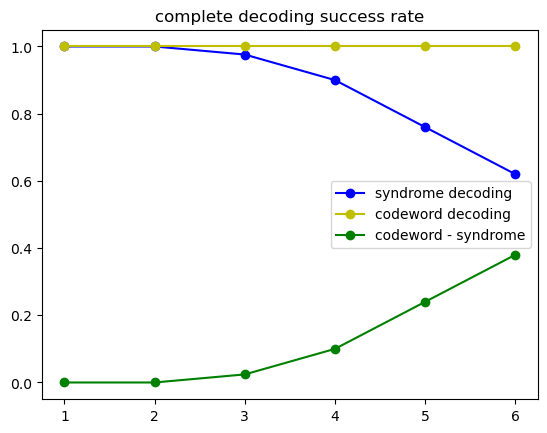

For LDPC with 76 parity check variables, 114 encoded logical bits:
Code Rate:0.3333333333333333

SYNDROME DECODING
CODEWORD DECODING


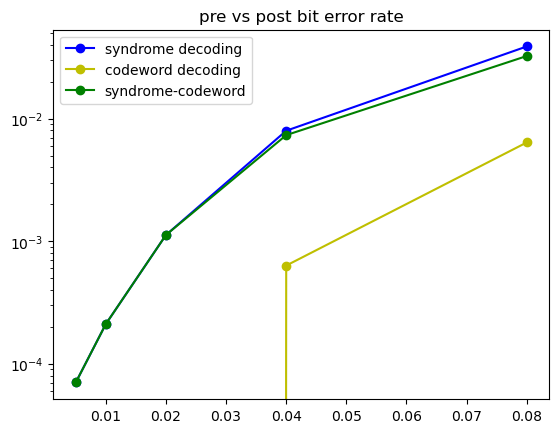

In [88]:
for M in [CM1]:
    distance_plot_test(M, verbose = 0)
    rate_plot_test(M, verbose =0)

## Select Investigations

In [64]:

broken = 0
broken_err = 0

M = altCM2
G = generator(M)
H = AIk(M)
#brute force distance tester
for _ in range(100000):
    x = random_data(M.shape[1])
    y = word_gen(G, x)
    syndrome = np.remainder(np.dot(H, y),2)
    corrupted = dist_error(y, 4)
    err_syndrome = np.remainder(np.dot(H, corrupted),2)
    difference = np.sum(np.remainder(err_syndrome - syndrome,2))

    if difference == 0:
        print("SEEEEE")
        broken = y
        broken_err = corrupted
        break

In [55]:
# this cell is a general demonstration of the process for decoding and such,

A = CM3
H = AIk(A)
G = wiki_generator(A)
x= random_data(A.shape[1])
y = word_gen(G,x)
dist = 2
error = np.array([0] * (H.shape[1]-dist) + [1] * (dist))
np.random.shuffle(error)
yhat = y+error
syndrome = np.remainder(np.dot(H,yhat),2)

# print(np.sum(np.abs(syndrome-np.remainder(np.dot(H,error),2))))

BP = syndrome_BP(H,syndrome,1000,0.02)
est_error, maxed = BP.decoder()
delta = np.sum(np.abs(error-est_error))
print(delta)
print(error)
print(est_error)
if np.sum(est_error) == 0:
    print("never got anything")
if delta == 0:
    print("correct")
# print(est_error-error)
# print(np.sum(np.abs(est_error-error)))

# #GtHt = 0
# np.any(np.remainder(np.dot(np.transpose(G),np.transpose(H)),2))


#number of checks per variable:
print(np.sum(altCM2, axis = 0))
distance = np.min(np.sum(altCM2, axis = 0)) + 1
print("distance = " + str(distance))

#number of variables per check:
print(np.sum(altCM2, axis = 1))

0.0
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
correct
[6 6 6 6 6 6 6 6 6 6 6 6]
distance = 7
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [55]:
# new version
A = CM1
H = A
print(H.shape)
G = np.transpose(orthogonalComplement(H))
x= random_data(A.shape[1])
y = word_gen(G,x)
dist = 2
error = np.array([0] * (H.shape[1]-dist) + [1] * (dist))
np.random.shuffle(error)
yhat = y+error
syndrome = np.remainder(np.dot(H,yhat),2)

# print(np.sum(np.abs(syndrome-np.remainder(np.dot(H,error),2))))

BP = syndrome_BP(H,syndrome,1000,0.02)
est_error, maxed = BP.decoder()
delta = np.sum(np.abs(error-est_error))
print(delta)
print(error)
print(est_error)
if np.sum(est_error) == 0:
    print("never got anything")
if delta == 0:
    print("correct")
# print(est_error-error)
# print(np.sum(np.abs(est_error-error)))

# #GtHt = 0
# np.any(np.remainder(np.dot(np.transpose(G),np.transpose(H)),2))


#number of checks per variable:
print(np.sum(altCM2, axis = 0))
distance = np.min(np.sum(altCM2, axis = 0)) + 1
print("distance = " + str(distance))

#number of variables per check:
print(np.sum(altCM2, axis = 1))

0.0
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
correct
[6 6 6 6 6 6 6 6 6 6 6 6]
distance = 7
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## Gradio integration (codeword decoding)
My idea is that the user inputs some int. I convert that to binary and reshape it to be a codeword for the bigger LDPC matrix, disturb with a given distance, and then recover it through BP decoding. 

In [9]:
def decimalToBinary(n):
    return bin(n).replace("0b", "")

def format_input(binstr, length):
    short = np.array([*binstr], dtype=np.int8)
    if len(short) <= length: 
        return np.pad(short, (length - len(short), 0), 'constant')
    else:
        raise ValueError("input too large")


In [10]:
description = "This is a toy belief propagation decoder. Pick an input number, error distance and LDPC encoding. \
Your number will convert to binary, then encode, then be corrupted by your error distance. See the decoded result given your choice of LDPC matrix.\
\n\n (It refreshes with every change to the input and might miss a change if the previous one is loading)"

def arr2string(arr):
    return ''.join(str(int(x)) for x in arr)

def greet(number, dist, size):
    #outputs binary, encoded binary, corrupted binary, recovered binary, decoded binary, int output, 
    if size == 'small':
        M = CM2
    else:
        M = CM1
    H1 = AIk(M)
    G1 = generator(M)
    
    try:
        number = int(number)
    except: 
        raise ValueError("not a number")
        
    #string
    binary = arr2string(format_input(decimalToBinary(number), H1.shape[1]-H1.shape[0]))
    
    #np array
    encbin = word_gen(G1, x=format_input(binary, M.shape[1]))
    
    #np array 
    corrupted = dist_error(encbin, dist)
    BP = Belief_prop(H1,corrupted,10,0.02)
   
    #np array 
    recovered, _ = BP.decoder()
    
    #np array 
    decoded = getx(H1,recovered)
    
    # int 

    out = int(arr2string(decoded),2 )

    return (
        binary, 
        arr2string(encbin),
        arr2string(corrupted),
        arr2string(recovered),
        arr2string(decoded),
        out)


In [11]:
demo = gr.Interface(
    fn=greet,
    inputs=["text", 
            gr.Slider(0, 5, step = 1, label = "Error Distance"), 
            gr.Radio(["small", "big"], label="LDPC matrix", info="How robust and large should the LDPC matrix be?", value = 'big')],
    outputs=[gr.Textbox(label="Input Binary"), gr.Textbox(label="Encoded Binary"),
             gr.Textbox(label="Corrupted Binary"),gr.Textbox(label="Binary Recovered after Belief Propagation Decoding"),
             gr.Textbox(label="Decoded Binary"), gr.Number(label = "Int Output")],
    theme=gr.themes.Monochrome(),
    title="Classical Belief Propagation decoding",
    description = description, 
    allow_flagging = 'never',
    live = True

)
demo.launch( share = False)

/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py:261: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(f"api_name {api_name} already exists, using {api_name_}")
/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py:261: UserWarning: api_name predict already exists, using predict_2
  warnings.warn(f"api_name {api_name} already exists, using {api_name_}")


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
